# An Introduction to Inference in Pyro

**Much of modern machine learning can be cast as approximate inference and expressed succinctly in a language like Pyro.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## A Simple Example

モデル

$$
p(weight|guess) \sim Normal(guess, 1) \\
p(measurement|guess) \sim Normal(weight, 0.75)
$$

In [2]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Conditioning

確率的プログラミングは、観測されたデータ上で生成モデルを条件づけし、そのデータを生成した潜在変数を推論できることに有用性がある。

観測値が9.5だったときの分布を考えたい。

$$
p(measurement|guess, measurement=9.5) \sim ?
$$

Pyroでは次のように条件づけできる

In [3]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [4]:
# メソッドにも出来る
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In [5]:
# obs引数を使えば直接条件付できる
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

## Flexible Approximate Inference With Guide Functions

ここ重要っぽいので、詳しく聞く

In [18]:
# 緑本の3.3.1に対応する
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    print(loc, scale)
    return pyro.sample("weight", dist.Normal(loc, scale))

In [19]:
guess = 8.5
perfect_guide(guess)

9.14 0.6


tensor(9.7417)

## Parametrized Stochastic Functions and Variational Inference


In [7]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

In [13]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [14]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

In [ ]:
# def scale_parametrized_guide_constrained(guess):
#     a = pyro.param("a", torch.tensor(guess))
#     b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
#     return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

a =  9.189955711364746
b =  0.6045947074890137


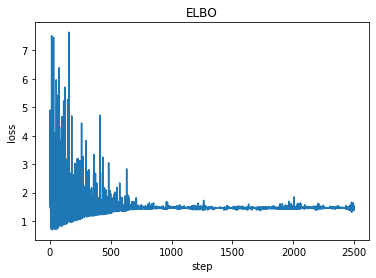

In [20]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())


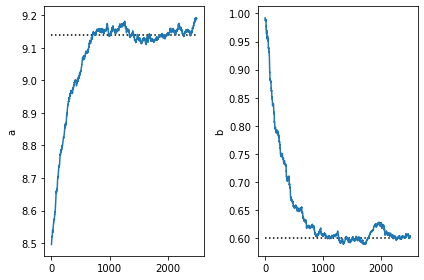

In [21]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()